In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from datetime import date
import warnings
warnings.filterwarnings("ignore")

sns.set()

## Data cleaning

In [2]:
path = "/Users/gaojinglun/Desktop/SPY OPTION CHAIN/spy_eod_2020-kwe0mi/spy_eod_202001.txt"
data = pd.read_csv(path)

# Check if all the observations are end of day data
assert sum(data[' [QUOTE_TIME_HOURS]'] == 16) == data.shape[0], 'Not end of day data'

# Convert date till expire in hour to year
data[' [DTE]'] = data[' [DTE]'].values / (24 * 365)

print('The uncleaned data has shape', data.shape)

The uncleaned data has shape (80250, 33)


In [3]:
# Select call data based on IV
Call_data = data[data[' [C_IV]'] != ' ']
# Convert string to float
Call_data[' [C_IV]'] = Call_data[' [C_IV]'].astype('float')
Call_data[' [C_BID]'] = Call_data[' [C_BID]'].astype('float')
Call_data[' [C_ASK]'] = Call_data[' [C_ASK]'].astype('float')

# Drop ' ' in teh quote date
Call_data[' [QUOTE_DATE]'] = Call_data[' [QUOTE_DATE]'].apply(lambda x: x[1:]).values

Call_data = Call_data[[' [QUOTE_DATE]', ' [UNDERLYING_LAST]', ' [STRIKE]', ' [DTE]', ' [C_DELTA]',
                       ' [C_BID]', ' [C_ASK]', ' [C_IV]', ' [C_VOLUME]']]

# Select put data based on IV
Put_data = data[data[' [P_IV]'] != ' ']
# Convert string to float
Put_data[' [P_IV]'] = Put_data[' [P_IV]'].astype('float')
Put_data[' [P_BID]'] = Put_data[' [P_BID]'].astype('float')
Put_data[' [P_ASK]'] = Put_data[' [P_ASK]'].astype('float')

# Drop ' ' in teh quote date
Put_data[' [QUOTE_DATE]'] = Put_data[' [QUOTE_DATE]'].apply(lambda x: x[1:]).values

Put_data = Put_data[[' [QUOTE_DATE]', ' [UNDERLYING_LAST]', ' [STRIKE]', ' [DTE]', ' [P_DELTA]',
                       ' [P_BID]', ' [P_ASK]', ' [P_IV]', ' [P_VOLUME]']]

print('The uncleaned call data has shape', Call_data.shape)
print('The uncleaned put data has shape', Put_data.shape)

The uncleaned call data has shape (78751, 9)
The uncleaned put data has shape (75205, 9)


In [4]:
print("Missing values in C_VOLUME", sum(Call_data[' [C_VOLUME]'] == ' '))
print("Missing values in P_VOLUME", sum(Put_data[' [P_VOLUME]'] == ' '))

Missing values in C_VOLUME 21657
Missing values in P_VOLUME 16386


     There are too many missing values in the Volume column, which makes it hard to use. Therefore, I will use the spread to see the liquidity of an option

In [5]:
Call_data.head()

,[QUOTE_DATE],[UNDERLYING_LAST],[STRIKE],[DTE],[C_DELTA],[C_BID],[C_ASK],[C_IV],[C_VOLUME]
79,2020-01-02,324.87,323.0,0.000114,0.887620,1.91,2.00,0.06431,
80,2020-01-02,324.87,323.5,0.000114,0.966980,1.35,1.40,0.03154,
81,2020-01-02,324.87,324.0,0.000114,0.736880,1.07,1.12,0.05721,
82,2020-01-02,324.87,324.5,0.000114,0.623960,0.67,0.70,0.04955,
83,2020-01-02,324.87,325.0,0.000114,0.462840,0.47,0.49,0.05641,


### Implied Vol

Each listed option has a unique sensitivity to implied volatility changes. For example, short-dated options will be less sensitive to implied volatility, while long-dated options will be more sensitive. This is based on the fact that long-dated options have more time value priced into them, while short-dated options have less.

<font color='red'>Why we keep obs with IV less then 1?</font>

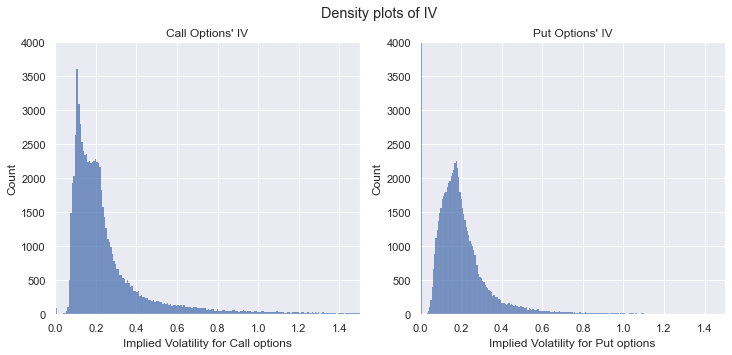

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
fig.suptitle('Density plots of IV')
sns.histplot(ax = axes[0], data = Call_data[' [C_IV]'])
axes[0].set_xlim(0, 1.5)
axes[0].set_ylim(0, 4000)
axes[0].set_xlabel("Implied Volatility for Call options")
axes[0].set_title("Call Options' IV")

sns.histplot(ax = axes[1], data = Put_data[' [P_IV]'])
axes[1].set_xlim(0, 1.5)
axes[1].set_ylim(0, 4000)
axes[1].set_xlabel("Implied Volatility for Put options")
axes[1].set_title("Put Options' IV")

plt.show()

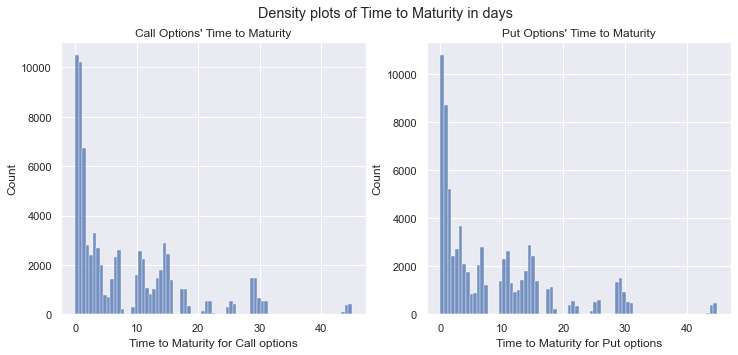

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
fig.suptitle('Density plots of Time to Maturity in days')
sns.histplot(ax = axes[0], data = Call_data[' [DTE]'].values * 365)
# axes[0].set_xlim(0, 0.14)
axes[0].set_xlabel("Time to Maturity for Call options")
axes[0].set_title("Call Options' Time to Maturity")

sns.histplot(ax = axes[1], data = Put_data[' [DTE]'].values * 365)
# axes[1].set_xlim(0, 0.14)
axes[1].set_xlabel("Time to Maturity for Put options")
axes[1].set_title("Put Options' Time to Maturity")

plt.show()

[Canceled Order](https://www.investopedia.com/terms/c/canceled_order.asp)

Limit orders for purchase that are lower than the bid price, or sell orders above the ask price, can usually be canceled online through a broker's online platform, or if necessary, by calling the broker directly. Good ‘til canceled (GTC) orders, which remain active until purged by the investor or the trade executes, can no longer be directly placed with the Nasdaq and New York Stock Exchange (NYSE). However, most brokerages continue to offer this order type.

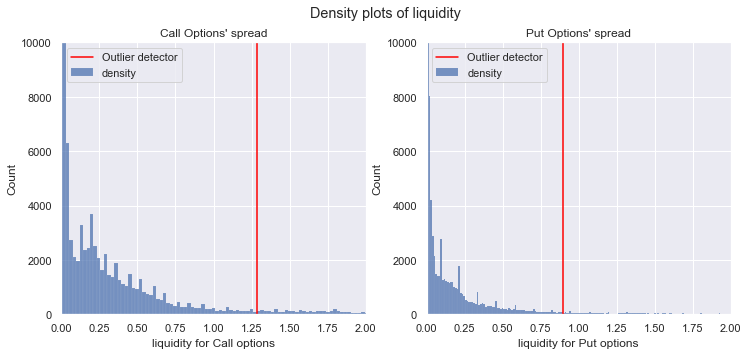

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
fig.suptitle('Density plots of liquidity')

# Using the Interquartile Rule to Find Outliers
c_percentile25 = np.percentile(Call_data[' [C_ASK]'] - Call_data[' [C_BID]'], 25)
c_percentile75 = np.percentile(Call_data[' [C_ASK]'] - Call_data[' [C_BID]'], 75)
c_spread_upper_bound = c_percentile75 + 1.5 * (c_percentile75 - c_percentile25)

sns.histplot(ax = axes[0], data = Call_data[' [C_ASK]'] - Call_data[' [C_BID]'], label = 'density')
axes[0].axvline(c_spread_upper_bound, color = 'red', label = 'Outlier detector')
axes[0].set_xlim(0, 2)
axes[0].set_ylim(0, 10000)
axes[0].set_xlabel("liquidity for Call options")
axes[0].set_title("Call Options' spread")
axes[0].legend(loc = "upper left")

# Using the Interquartile Rule to Find Outliers
p_percentile25 = np.percentile(Put_data[' [P_ASK]'] - Put_data[' [P_BID]'], 25)
p_percentile75 = np.percentile(Put_data[' [P_ASK]'] - Put_data[' [P_BID]'], 75)
p_spread_upper_bound = c_percentile75 + 1.5 * (p_percentile75 - p_percentile25)

sns.histplot(ax = axes[1], data = Put_data[' [P_ASK]'] - Put_data[' [P_BID]'], label = 'density')
axes[1].axvline(p_spread_upper_bound, color = 'red', label = 'Outlier detector')
axes[1].set_xlim(0, 2)
axes[1].set_ylim(0, 10000)
axes[1].set_xlabel("liquidity for Put options")
axes[1].set_title("Put Options' spread")
axes[1].legend(loc = "upper left")

plt.show()

In [9]:
n = Call_data.shape[0]
print("There are {} call options with nonpositive IV, in {}%.".format(
    sum(Call_data[' [C_IV]'] <= 0), 
    np.round(100 * sum(Call_data[' [C_IV]'] < 0) / n, 4)
))
Call_data = Call_data[Call_data[' [C_IV]'] > 0]

print("There are {} call options with IV greater then 1, in {}%.".format(
    sum(Call_data[' [C_IV]'] > 1), 
    np.round(100 * sum(Call_data[' [C_IV]'] > 1) / n, 4)
))
Call_data = Call_data[Call_data[' [C_IV]'] <= 1]

print("There are {} call options with Time to Maturity less then one day, in {}%.".format(
    sum(Call_data[' [DTE]'] == 0), 
    np.round(100 * sum(Call_data[' [DTE]'] <= 1 / 365) / n, 4)
))
Call_data = Call_data[Call_data[' [DTE]'] > 1 / 365]

print("There are {} call options with negative spread, in {}%.".format(
    sum(Call_data[' [C_ASK]'] - Call_data[' [C_BID]'] <= 0), 
    np.round(100 * sum(Call_data[' [C_ASK]'] - Call_data[' [C_BID]'] <= 0) / n, 4)
))
Call_data = Call_data[Call_data[' [C_ASK]'] - Call_data[' [C_BID]'] > 0]

print("There are {} call options greater then the Interquartile Rule's upper bound, in {}%.".format(
    sum(Call_data[' [C_ASK]'] - Call_data[' [C_BID]'] > c_spread_upper_bound), 
    np.round(100 * sum(Call_data[' [C_ASK]'] - Call_data[' [C_BID]'] > c_spread_upper_bound) / n, 4)
))
Call_data = Call_data[Call_data[' [C_ASK]'] - Call_data[' [C_BID]'] <= c_spread_upper_bound]

print("Finally, we keep {} % of the original call options.".format(
    np.round(Call_data.shape[0] / n, 4)
))

There are 49 call options with nonpositive IV, in 0.0584%.
There are 3266 call options with IV greater then 1, in 4.1472%.
There are 755 call options with Time to Maturity less then one day, in 22.7299%.
There are 1065 call options with negative spread, in 1.3524%.
There are 8600 call options greater then the Interquartile Rule's upper bound, in 10.9205%.
Finally, we keep 0.6079 % of the original call options.


In [10]:
n = Put_data.shape[0]
print("There are {} put options with nonpositive IV, in {}%.".format(
    sum(Put_data[' [P_IV]'] <= 0), np.round(100 * sum(Put_data[' [P_IV]'] < 0) / n)
))
Put_data = Put_data[Put_data[' [P_IV]'] > 0]

print("There are {} put options with IV greater then 1, in {}%.".format(
    sum(Put_data[' [P_IV]'] > 1), np.round(100 * sum(Put_data[' [P_IV]'] > 1) / n)
))
Put_data = Put_data[Put_data[' [P_IV]'] <= 1]

print("There are {} call options with Time to Maturity less then one day, in {}%.".format(
    sum(Put_data[' [DTE]'] <= 1 / 365), 
    np.round(100 * sum(Put_data[' [DTE]'] <= 1 / 365) / n, 4)
))
Put_data = Put_data[Put_data[' [DTE]'] > 1 / 365]

print("There are {} call options with negative spread, in {}%.".format(
    sum(Put_data[' [P_ASK]'] - Put_data[' [P_BID]'] <= 0), 
    np.round(100 * sum(Put_data[' [P_ASK]'] - Put_data[' [P_BID]'] <= 0) / n, 4)
))
Put_data = Put_data[Put_data[' [P_ASK]'] - Put_data[' [P_BID]'] > 0]

print("There are {} call options greater then the Interquartile Rule's upper bound, in {}%.".format(
    sum(Put_data[' [P_ASK]'] - Put_data[' [P_BID]'] > p_spread_upper_bound), 
    np.round(100 * sum(Put_data[' [P_ASK]'] - Put_data[' [P_BID]'] > p_spread_upper_bound) / n, 4)
))
Put_data = Put_data[Put_data[' [P_ASK]'] - Put_data[' [P_BID]'] <= p_spread_upper_bound]

print("Finally, we keep {} % of the original put options.".format(
    np.round(Put_data.shape[0] / n, 4)
))

There are 2518 put options with nonpositive IV, in 3.0%.
There are 924 put options with IV greater then 1, in 1.0%.
There are 16361 call options with Time to Maturity less then one day, in 21.7552%.
There are 2380 call options with negative spread, in 3.1647%.
There are 4063 call options greater then the Interquartile Rule's upper bound, in 5.4026%.
Finally, we keep 0.651 % of the original put options.


## Liquidity

In [11]:
Call_spread = Call_data[' [C_ASK]'] - Call_data[' [C_BID]']
Call_spread_min = np.min(Call_spread)
Call_spread_max = np.max(Call_spread)
Call_data['LIQUIDITY'] = (Call_spread - Call_spread_min) / (Call_spread_max - Call_spread_min)

Put_spread = Put_data[' [P_ASK]'] - Put_data[' [P_BID]']
Put_spread_min = np.min(Put_spread)
Put_spread_max = np.max(Put_spread)
Put_data['LIQUIDITY'] = (Put_spread - Put_spread_min) / (Put_spread_max - Put_spread_min)

## Interest rate

In [12]:
interest_rate = pd.read_csv("DGS1MO.csv")
interest_rate_2020_01 = interest_rate.loc[interest_rate['DATE'].str.startswith('2020-01-')].copy()
interest_rate_2020_01 = interest_rate_2020_01.rename({'DATE': ' [QUOTE_DATE]'}, axis='columns')
IR = interest_rate_2020_01['DGS1MO'][interest_rate_2020_01['DGS1MO'] != '.'].astype('float').mean()
IR

1.5333333333333332

In [13]:
# Add interest rate to the data
Call_data = Call_data.merge(interest_rate_2020_01, on = ' [QUOTE_DATE]', how = 'left')
Call_data = Call_data.drop([' [C_VOLUME]'], axis = 1)

Put_data = Put_data.merge(interest_rate_2020_01, on = ' [QUOTE_DATE]', how = 'left')
Put_data = Put_data.drop([' [P_VOLUME]'], axis = 1)

## SPY

In [14]:
SPY = pd.read_csv("SPY.csv")

# Underlying asset price in 2020 01 from OptionDX
OptionDX_SPY = Call_data.groupby([' [QUOTE_DATE]']).mean()[' [UNDERLYING_LAST]'].values

print('The MAPE of data from yahoo finance SPY(Close) and last traded underlying asset price from OptionDX is', 
     np.round(mean_absolute_percentage_error(SPY.Close[:21], OptionDX_SPY), 10))

The MAPE of data from yahoo finance SPY(Close) and last traded underlying asset price from OptionDX is 0.0001017239


## Calculate the "actual" Options price

In [15]:
def get_date(time):
    '''
    Convert time in '2020-01-02' to date class
    '''
    year, month, days = time[:4], time[5:7], time[-2:]

    if month[0] == '0':
        month = month[1]
        
    if days[0] == '0':
        days = int(days[1])
        
    return date(int(year), int(month), int(days))
    

def get_call_options_price(quote_date, S, K, T, R, IR):
    '''
    T in years
    IR in 100%
    Also need the SPY historical prices
    '''
    start_idx = list(SPY['Date']).index(quote_date)
    # end date is at least one day from start 
    end_idx = start_idx + 1
    
    start = SPY['Date'].values[start_idx]
    # convert '2020-01-02' to date class
    start_date = get_date(start)
    
    # get the end day idx
    while (get_date(SPY['Date'].values[end_idx]) - start_date).days < T * 365:
        end_idx += 1
    
    profit = [SPY.Close.values[i] - K for i in range(start_idx, end_idx + 1)]
    max_idx = np.argmax(profit)
    max_profit = profit[max_idx]
    days = (get_date(SPY['Date'].values[max_idx]) - start_date).days / 365
    # Using simple interest
    Options_price = max_profit  / (1 + days * IR  / 100)
        
    return Options_price, SPY['Date'].values[end_idx]

In [16]:
call_options_prices = [get_call_options_price(Call_data[' [QUOTE_DATE]'].values[i],
                       Call_data[' [UNDERLYING_LAST]'].values[i],
                       Call_data[' [STRIKE]'].values[i],
                       Call_data[' [DTE]'].values[i],
                       Call_data['DGS1MO'].values[i],
                       IR
)[0] for i in range(Call_data.shape[0])]
Call_data['OPTIONS_PRICE'] = call_options_prices

end_date = [get_call_options_price(Call_data[' [QUOTE_DATE]'].values[i],
                       Call_data[' [UNDERLYING_LAST]'].values[i],
                       Call_data[' [STRIKE]'].values[i],
                       Call_data[' [DTE]'].values[i],
                       Call_data['DGS1MO'].values[i],
                       IR
)[1] for i in range(Call_data.shape[0])]
Call_data['END_DATE'] = end_date

In [17]:
Call_data = Call_data.rename({' [QUOTE_DATE]': 'START_DATE',
                              ' [UNDERLYING_LAST]': 'UNDERLYING',
                              ' [STRIKE]': 'SKRIKE',
                              ' [DTE]': 'MATURITY',
                              ' [C_DELTA]': 'DELTA',
                              ' [C_BID]' : 'BID',
                              ' [C_ASK]': 'ASK',
                              ' [C_IV]': 'IMPLIED_VOL',
                              'DGS1MO': 'INTEREST_RATE'
                             }, axis='columns')
Call_data.head()

,START_DATE,UNDERLYING,SKRIKE,MATURITY,DELTA,BID,ASK,IMPLIED_VOL,LIQUIDITY,INTEREST_RATE,OPTIONS_PRICE,END_DATE
0,2020-01-02,324.87,270.0,0.002854,0.984240,54.91,55.15,0.32756,0.181102,1.53,54.869995,2020-01-06
1,2020-01-02,324.87,275.0,0.002854,0.991900,49.83,50.04,0.26110,0.157480,1.53,49.869995,2020-01-06
2,2020-01-02,324.87,280.0,0.002854,0.975140,44.72,45.51,0.28942,0.614173,1.53,44.869995,2020-01-06
3,2020-01-02,324.87,285.0,0.002854,0.979570,39.93,40.13,0.24333,0.149606,1.53,39.869995,2020-01-06
4,2020-01-02,324.87,290.0,0.002854,0.963990,35.06,35.27,0.24022,0.157480,1.53,34.869995,2020-01-06


In [18]:
def get_put_options_price(quote_date, S, K, T, R, IR):
    '''
    T in years
    IR in 100%
    Also need the SPY historical prices
    '''
    start_idx = list(SPY['Date']).index(quote_date)
    # end date is at least one day from start 
    end_idx = start_idx + 1
    
    start = SPY['Date'].values[start_idx]
    # convert '2020-01-02' to date class
    start_date = get_date(start)
    
    # get the end day idx
    while (get_date(SPY['Date'].values[end_idx]) - start_date).days < T * 365:
        end_idx += 1
    
    profit = [K - SPY.Close.values[i] for i in range(start_idx, end_idx + 1)]
    max_idx = np.argmax(profit)
    max_profit = profit[max_idx]
    days = (get_date(SPY['Date'].values[max_idx]) - start_date).days / 365
    # Using simple interest
    Options_price = max_profit  / (1 + days * IR  / 100)
        
    return Options_price, SPY['Date'].values[end_idx]

In [19]:
put_options_prices = [get_put_options_price(Put_data[' [QUOTE_DATE]'].values[i],
                       Put_data[' [UNDERLYING_LAST]'].values[i],
                       Put_data[' [STRIKE]'].values[i],
                       Put_data[' [DTE]'].values[i],
                       Put_data['DGS1MO'].values[i],
                       IR
)[0] for i in range(Put_data.shape[0])]
Put_data['OPTIONS_PRICE'] = put_options_prices

end_date = [get_put_options_price(Put_data[' [QUOTE_DATE]'].values[i],
                       Put_data[' [UNDERLYING_LAST]'].values[i],
                       Put_data[' [STRIKE]'].values[i],
                       Put_data[' [DTE]'].values[i],
                       Put_data['DGS1MO'].values[i],
                       IR
)[1] for i in range(Put_data.shape[0])]
Put_data['END_DATE'] = end_date

In [20]:
Put_data = Put_data.rename({' [QUOTE_DATE]': 'START_DATE',
                              ' [UNDERLYING_LAST]': 'UNDERLYING',
                              ' [STRIKE]': 'SKRIKE',
                              ' [DTE]': 'MATURITY',
                              ' [P_DELTA]': 'DELTA',
                              ' [P_BID]' : 'BID',
                              ' [P_ASK]': 'ASK',
                              ' [P_IV]': 'IMPLIED_VOL',
                              'DGS1MO': 'INTEREST_RATE'
                             }, axis='columns')
Put_data.head()

,START_DATE,UNDERLYING,SKRIKE,MATURITY,DELTA,BID,ASK,IMPLIED_VOL,LIQUIDITY,INTEREST_RATE,OPTIONS_PRICE,END_DATE
0,2020-01-02,324.87,270.0,0.002854,-0.006800,0.05,0.06,0.28440,2.365532e-16,1.53,-52.407802,2020-01-06
1,2020-01-02,324.87,275.0,0.002854,-0.008790,0.07,0.08,0.26526,2.365532e-16,1.53,-47.408012,2020-01-06
2,2020-01-02,324.87,280.0,0.002854,-0.011020,0.08,0.09,0.24827,2.365532e-16,1.53,-42.408222,2020-01-06
3,2020-01-02,324.87,285.0,0.002854,-0.016170,0.11,0.13,0.23112,1.136364e-02,1.53,-37.408433,2020-01-06
4,2020-01-02,324.87,299.0,0.002854,-0.043410,0.28,0.29,0.18376,1.892426e-16,1.53,-23.409021,2020-01-06


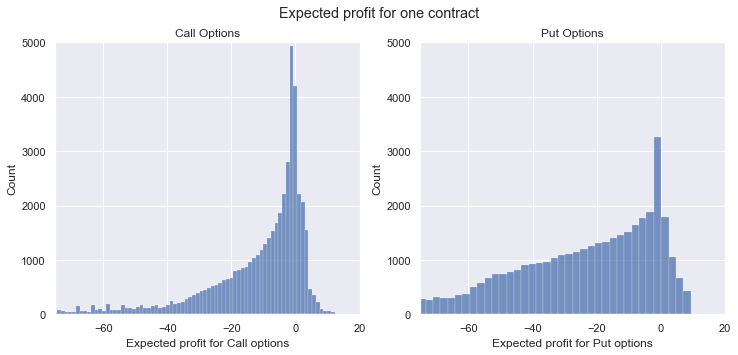

In [21]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
fig.suptitle('Expected profit for one contract')
sns.histplot(ax = axes[0], data = Call_data['OPTIONS_PRICE'] - Call_data['ASK'], bins = 150)
axes[0].set_xlim(-75, 20)
axes[0].set_ylim(0, 5000)
axes[0].set_xlabel("Expected profit for Call options")
axes[0].set_title("Call Options")

sns.histplot(ax = axes[1], data = Put_data['OPTIONS_PRICE'] - Put_data['ASK'], bins = 150)
axes[1].set_xlim(-75, 20)
axes[1].set_ylim(0, 5000)
axes[1].set_xlabel("Expected profit for Put options")
axes[1].set_title("Put Options")

plt.show()

In [22]:
Call_data.to_csv("/Users/gaojinglun/Desktop/Call_data.csv")
Put_data.to_csv("/Users/gaojinglun/Desktop/Put_data.csv")

OTM Options might have negative values